# Estimation of factor sensitivities

## Data generation

We create a 3 factor model for a return time series. We will take the sensitivities to the factors to be time dependent, with the following shapes:
- A random smooth stationary series.
- A smooth increase, then decrease.
- A step function from 0 to 1. 
The factors themselves will be stationary time series. For now we take them to be random white noise. We could also take them to be smooth functions. In addition there is idiosynchratic component to the returns, which is a white noise too.

## Making the study rigorous

Ideas:
- Parallelize the code.
- We could use non-gaussian noise.
- We could vary the intensity of the noise (but this will require to reestimate the windo of the rolling regression and the covariances of the Kalman filters.


In [125]:
%matplotlib inline
import importlib
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from pyfinance.ols import OLS, RollingOLS, PandasRollingOLS
import pykalman
from pykalman import KalmanFilter
from scipy.interpolate import splrep, splev
import multiprocessing as mp
from functools import partial

import functions_kalman as fk

In [126]:
# Sensitivity type
sens_type = "Random smooth" # "Random walk" # "Various smooth" #c
burn_period = 500
return_noise = 1.0

In [233]:
# Strategy parameters
if sens_type == "Random walk":
    # Rolling window for ols regression
    rolling_ols_window = 400
    # Lambda parameter for exponentially weighted ols regression
    exp_rolling_ols_lambda = 0.005
    # Transition covariance/observatiaion covariance for the Kalman filter 
    kalman_covariance_ratio = 0.00002
    # "Momentum" for the naive trend Kalman filter
    nt_factor = 0.5
    # Rolling window over which to compute the momentum
    nt_window = 100
    # Transition covariance/observation covariance for the stochastic trend Kalman filter.
    stkf_covariance_ratio = 2e-10
elif sens_type == "Various smooth":
    rolling_ols_window = 200
    exp_rolling_ols_lambda = 0.01
    kalman_covariance_ratio = 0.0001
    stkf_covariance_ratio = 1e-9
    nt_factor = 0.5
    nt_window = 100
elif sens_type == "Random smooth":
    rolling_ols_window = 100
    exp_rolling_ols_lambda=0.02 #0.005
    kalman_covariance_ratio = 2e-4
    stkf_covariance_ratio = 5e-9
    nt_factor = 0.5
    nt_window = 100

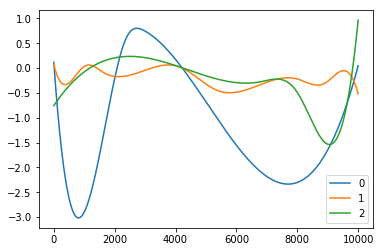

In [128]:
# Sensitivities
timespan = 10000
sens = fk.get_sensitivities(timespan, sens_type)
sens.plot()

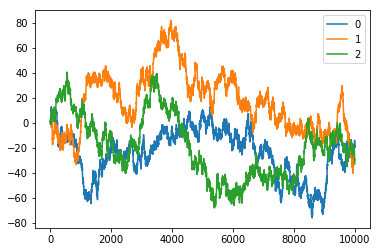

In [129]:
# Factors
factors = fk.get_factors(timespan)
factors.cumsum(axis=0).plot()

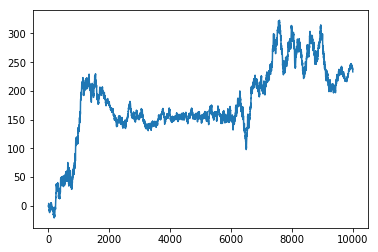

In [130]:
# Returns
returns = fk.get_returns(timespan, factors, sens, return_noise)
returns.cumsum().plot()

In [131]:
# Dictionaries to record the mse and the weighted accuracy
performance_record_mse = {}
performance_record_wacc = {}
# To have consistent colors in the plots
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

## Constant regression

In [132]:
estimated_sensitivities_cr = fk.estimate_sensitivities_cr(factors, returns)
estimated_sensitivities_cr

,0,1,2
0,-1.148532,-0.219808,-0.276092
1,-1.148532,-0.219808,-0.276092
2,-1.148532,-0.219808,-0.276092
3,-1.148532,-0.219808,-0.276092
4,-1.148532,-0.219808,-0.276092
5,-1.148532,-0.219808,-0.276092
6,-1.148532,-0.219808,-0.276092
7,-1.148532,-0.219808,-0.276092
8,-1.148532,-0.219808,-0.276092
9,-1.148532,-0.219808,-0.276092


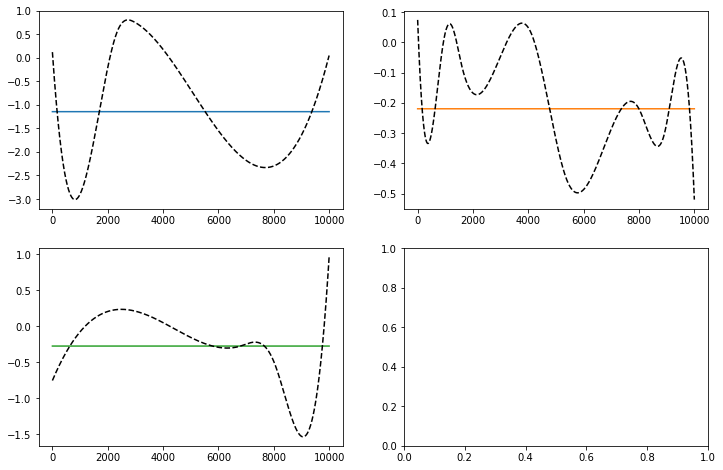

In [133]:
fk.plot_estimated_sensitivities(sens, estimated_sensitivities_cr, colors)

MSE for Constant OLS, assuming the factors known: 2.512769505887211
Weighted accuracy for Constant OLS, assuming the factors known: 0.9559324723208501


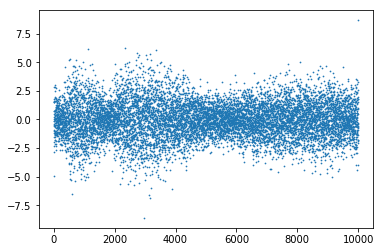

In [134]:
fk.plot_prediction_performance(factors, returns, estimated_sensitivities_cr, "Constant OLS", 
                            performance_record_mse, performance_record_wacc)

## Rolling regression

In [135]:
window = rolling_ols_window
estimated_sensitivities_rr = fk.estimate_sensitivities_rr(factors, returns, window)
estimated_sensitivities_rr

,0,1,2
99,-0.323322,0.006522,-0.655182
100,-0.330925,0.014200,-0.653916
101,-0.350985,0.010729,-0.646585
102,-0.350606,0.013064,-0.649692
103,-0.353414,0.016007,-0.642738
104,-0.380930,-0.041306,-0.676080
105,-0.381362,-0.043624,-0.668050
106,-0.376805,-0.036646,-0.659732
107,-0.374606,-0.040619,-0.660055
108,-0.366020,-0.058251,-0.668227


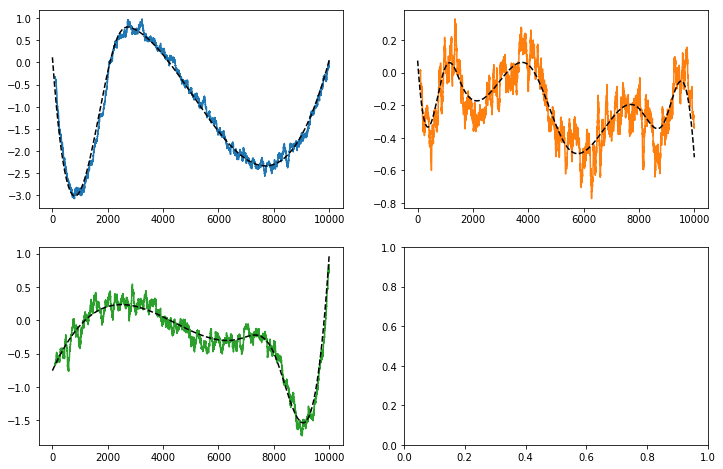

In [136]:
fk.plot_estimated_sensitivities(sens, estimated_sensitivities_rr, colors)

MSE for Rolling OLS, assuming the factors known: 1.0256410847505517
Weighted accuracy for Rolling OLS, assuming the factors known: 1.192616058200663


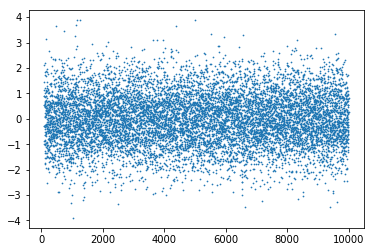

In [137]:
fk.plot_prediction_performance(factors.iloc[window-1:,:], 
                               returns.iloc[window-1:], 
                               estimated_sensitivities_rr, 
                               "Rolling OLS",
                               performance_record_mse,
                               performance_record_wacc)

## Exponential rolling regression

In [138]:
estimated_sensitivities_err = fk.estimate_sensitivities_err(factors, returns, exp_rolling_ols_lambda)

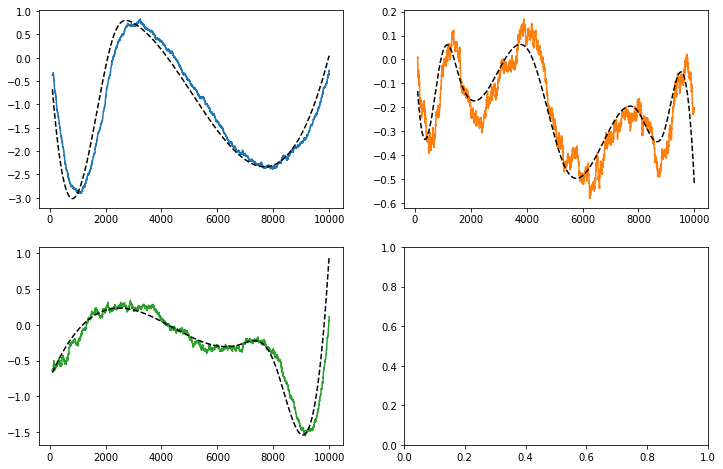

In [139]:
fk.plot_estimated_sensitivities(sens.iloc[100:,:], estimated_sensitivities_err.iloc[100:,:], colors)

MSE for Exponential rolling OLS, assuming the factors known: 1.0926841858848362
Weighted accuracy for Exponential rolling OLS, assuming the factors known: 1.1696284660601899


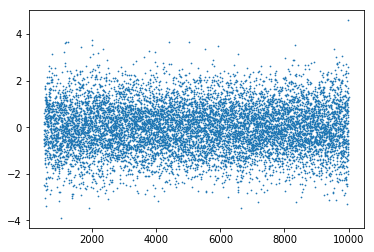

In [140]:
fk.plot_prediction_performance(factors.iloc[burn_period:,:], 
                               returns.iloc[burn_period:], 
                               estimated_sensitivities_err.iloc[burn_period:,:], 
                               "Exponential rolling OLS",
                               performance_record_mse,
                               performance_record_wacc)

## Kalman filter

In [141]:
covariance_ratio = kalman_covariance_ratio
estimated_sensitivities_kf = fk.estimate_sensitivities_kf(factors, returns, covariance_ratio)
estimated_sensitivities_kf

,0,1,2
0,-0.028146,-0.146375,-0.331466
1,0.493922,-0.022283,-0.424584
2,0.485199,0.002181,-0.442734
3,0.476787,0.044614,-0.452781
4,0.511506,0.075206,-0.400392
5,0.566731,0.080113,-0.482073
6,0.451021,0.144368,-0.554998
7,0.440845,0.230006,-0.661182
8,0.312427,0.389544,-0.662798
9,0.458152,0.507167,-0.763166


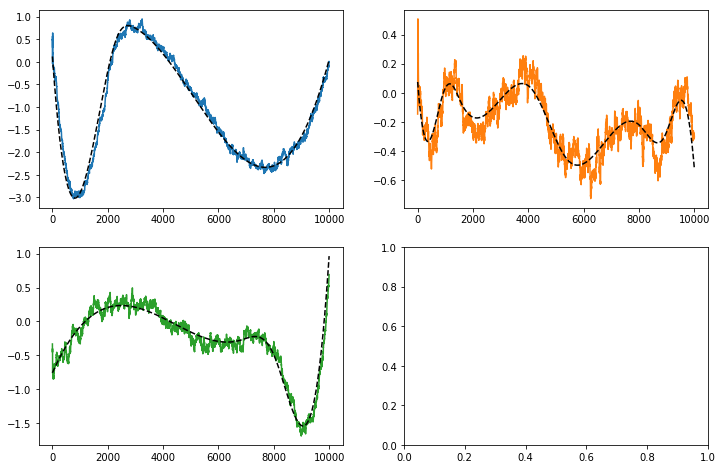

In [142]:
fk.plot_estimated_sensitivities(sens, estimated_sensitivities_kf, colors)

MSE for Kalman, assuming the factors known: 1.0233500496585068
Weighted accuracy for Kalman, assuming the factors known: 1.1901470742011984


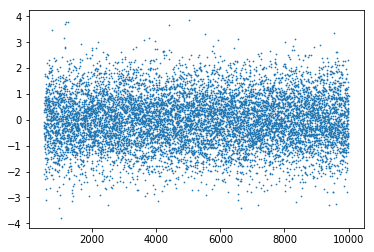

In [143]:
fk.plot_prediction_performance(factors.iloc[burn_period:,:], 
                               returns.iloc[burn_period:], 
                               estimated_sensitivities_kf.iloc[burn_period:,:], 
                               "Kalman",
                               performance_record_mse,
                               performance_record_wacc)

In [144]:
# Naive trend correction...
trend_factor = .5
window = 100
estimated_sensitivities_kf_ntc = fk.estimate_sensitivities_ntc(estimated_sensitivities_kf, trend_factor, window)
estimated_sensitivities_kf_ntc

,0,1,2
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
5,NaN,NaN,NaN
6,NaN,NaN,NaN
7,NaN,NaN,NaN
8,NaN,NaN,NaN
9,NaN,NaN,NaN


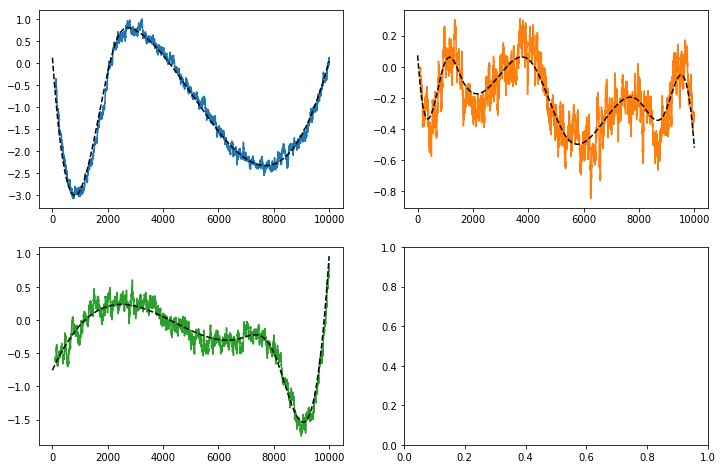

In [145]:
fk.plot_estimated_sensitivities(sens, estimated_sensitivities_kf_ntc, colors)

MSE for Kalman naive trend, assuming the factors known: 1.0278796952426061
Weighted accuracy for Kalman naive trend, assuming the factors known: 1.1859982545292378


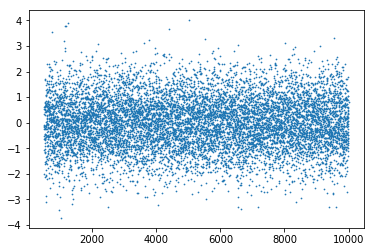

In [146]:
fk.plot_prediction_performance(factors.iloc[burn_period:,:], 
                               returns.iloc[burn_period:], 
                               estimated_sensitivities_kf_ntc.iloc[burn_period:,:], 
                               "Kalman naive trend",
                               performance_record_mse,
                               performance_record_wacc)

## Stochastic trend Kalman filter

In [147]:
estimated_sensitivities_stkf = fk.estimate_sensitivities_stkf(factors, returns, stkf_covariance_ratio)
estimated_sensitivities_stkf

,0,1,2
0,-0.028146,-0.146375,-0.331466
1,0.588710,0.002057,-0.437133
2,0.879171,0.118310,-0.538586
3,1.188459,0.115391,-0.637860
4,1.322911,0.042442,-1.026985
5,0.766518,0.137984,-0.531616
6,0.252327,0.693402,-0.772586
7,0.190656,0.893403,-0.889203
8,0.182989,0.968608,-0.977528
9,0.178587,1.152277,-1.081340


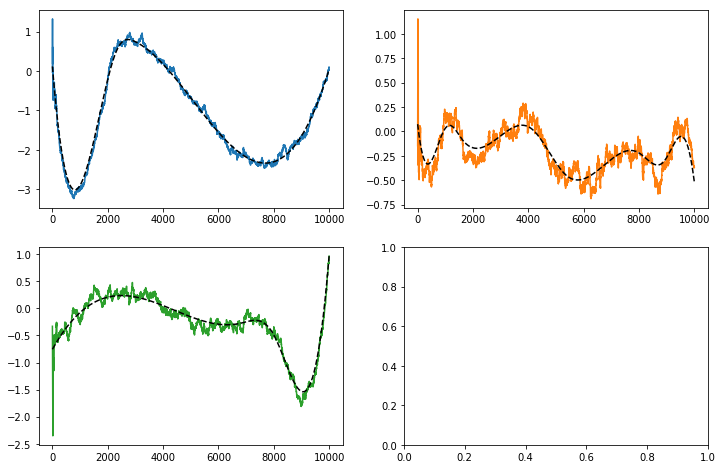

In [148]:
fk.plot_estimated_sensitivities(sens, estimated_sensitivities_stkf, colors)

MSE for Kalman stoch trend, assuming the factors known: 1.015312448440885
Weighted accuracy for Kalman stoch trend, assuming the factors known: 1.1868317608645407


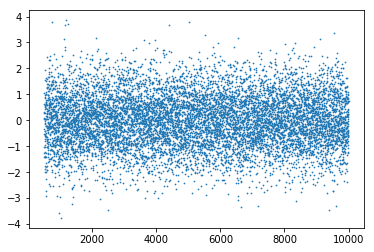

In [149]:
fk.plot_prediction_performance(factors.iloc[burn_period:,:], 
                               returns.iloc[burn_period:], 
                               estimated_sensitivities_stkf.iloc[burn_period:,:], 
                               "Kalman stoch trend",
                               performance_record_mse,
                               performance_record_wacc)

## Performance summary

In [150]:
pd.Series(performance_record_mse).sort_values()

Kalman stoch trend         1.015312
Kalman                     1.023350
Rolling OLS                1.025641
Kalman naive trend         1.027880
Exponential rolling OLS    1.092684
Constant OLS               2.512770
dtype: float64

In [151]:
pd.Series(performance_record_wacc).sort_values(ascending=False)

Rolling OLS                1.192616
Kalman                     1.190147
Kalman stoch trend         1.186832
Kalman naive trend         1.185998
Exponential rolling OLS    1.169628
Constant OLS               0.955932
dtype: float64

## Optimisation of the hyperparameters

### Rolling OLS

In [107]:
importlib.reload(fk)
performance_record_mse, performance_record_wacc = fk.compare_hyperparameters_mp("Rolling OLS", 
                                                                             1000,
                                                                             timespan,
                                                                             sens_type,
                                                                             return_noise,
                                                                             rolling_ols_window=[50, 100, 200, 300],
                                                                             )

5
0
2
3
1
4
7
8
9
10
11
12
6
13
14
15
16
17
18
19
20
21
22
23
24
25
27
26
28
29
30
31
32
33
34
35
36
37
38
39
40
42
41
43
44
45
47
46
48
49
50
53
51
52
54
55
58
57
56
59
60
61
62
63
64
66
67
65
68
69
70
71
72
73
75
74
76
77
78
79
80
81
83
82
84
85
86
87
88
89
91
90
92
94
93
95
97
96
98
99
100
101
103
102
104
105
106
109
107
108
110
111
112
113
114
115
116
117
118
121
120
122
119
123
125
124
126
127
128
131
130
129
132
133
134
135
136
137
139
138
140
141
142
143
144
145
146
147
148
150
149
151
152
154
153
155
156
157
158
159
160
161
163
162
164
167
165
166
168
169
170
171
172
173
174
176
175
177
179
178
180
181
182
185
184
183
186
187
188
189
190
191
193
192
194
195
196
197
198
199
201
202
200
204
203
205
206
208
207
209
210
211
212
213
214
215
217
216
218
219
220
221
223
222
225
224
226
227
229
228
230
231
232
233
235
234
236
237
238
241
239
240
242
243
244
245
246
248
247
249
250
251
252
253
254
256
255
257
258
259
260
261
262
264
263
265
266
267
268
269
270
273
272
274
271
275
276
27

In [108]:
performance_record_wacc.describe()

,Rolling OLS - {'rolling_ols_window': 100},Rolling OLS - {'rolling_ols_window': 200},Rolling OLS - {'rolling_ols_window': 300},Rolling OLS - {'rolling_ols_window': 50}
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.378086,1.374815,1.365921,1.371296
std,0.831940,0.825101,0.817991,0.836849
min,0.265339,0.271234,0.286986,0.244272
25%,0.734763,0.738525,0.735639,0.722494
50%,1.113264,1.110436,1.101585,1.104553
75%,1.772377,1.768297,1.744477,1.770483
max,4.616666,4.608285,4.597910,4.620459


In [109]:
importlib.reload(fk)
fk.compute_t_stat(performance_record_wacc)

Rolling OLS - {'rolling_ols_window': 100}          NaN
Rolling OLS - {'rolling_ols_window': 200}    -7.019601
Rolling OLS - {'rolling_ols_window': 300}   -12.688414
Rolling OLS - {'rolling_ols_window': 50}    -26.334138
dtype: float64


### Exponential rolling OLS

In [110]:
performance_record_mse, performance_record_wacc = fk.compare_hyperparameters_mp("Exponential rolling OLS", 1000, timespan,
                                                    sens_type, return_noise, 
                                                    exp_rolling_ols_lambda=[0.002, 0.005, 0.01, 0.02, 0.05])

0
3
2
4
1
5
6
7
10
8
9
11
12
14
15
17
16
18
19
13
20
21
22
23
24
25
26
27
28
29
30
31
32
34
35
36
37
38
39
33
40
41
43
42
44
45
46
47
48
49
50
51
52
54
55
56
57
58
53
59
60
61
62
63
64
66
65
67
68
69
70
71
72
74
75
76
77
78
73
79
80
81
82
83
84
86
85
87
88
89
90
91
92
94
93
95
96
97
98
99
100
102
103
104
105
106
101
107
108
109
110
111
112
114
113
115
116
117
118
119
120
122
123
124
125
126
121
127
128
129
130
131
132
134
133
135
136
137
138
139
140
143
142
144
145
146
141
147
148
149
150
151
152
154
153
155
156
157
159
158
160
162
164
163
165
166
161
167
168
170
169
171
172
174
173
175
176
177
178
179
180
182
183
184
185
186
181
187
188
189
190
191
192
194
193
195
196
197
198
199
200
202
203
204
205
206
201
207
208
209
210
211
212
214
213
215
216
217
218
219
220
222
223
224
225
226
221
227
228
229
230
231
232
234
233
235
236
237
238
239
240
242
243
244
245
246
241
247
248
249
250
251
252
254
253
255
256
257
258
259
260
262
263
264
265
266
261
267
268
269
270
271
272
274
273
275
276
27

In [111]:
performance_record_wacc.describe()

,Exponential rolling OLS - {'exp_rolling_ols_lambda': 0.002},Exponential rolling OLS - {'exp_rolling_ols_lambda': 0.005},Exponential rolling OLS - {'exp_rolling_ols_lambda': 0.01},Exponential rolling OLS - {'exp_rolling_ols_lambda': 0.02},Exponential rolling OLS - {'exp_rolling_ols_lambda': 0.05}
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.294265,1.354657,1.369374,1.371058,1.360394
std,0.823577,0.849236,0.858352,0.863300,0.869082
min,0.298366,0.320560,0.315622,0.308175,0.275133
25%,0.694402,0.734531,0.743254,0.741076,0.726942
50%,0.978071,1.041028,1.050992,1.047958,1.039070
75%,1.626794,1.729562,1.749625,1.760525,1.753139
max,4.826245,4.886530,4.893869,4.897393,4.897324


In [112]:
fk.compute_t_stat(performance_record_wacc)

Exponential rolling OLS - {'exp_rolling_ols_lambda': 0.002}          NaN
Exponential rolling OLS - {'exp_rolling_ols_lambda': 0.005}    33.146928
Exponential rolling OLS - {'exp_rolling_ols_lambda': 0.01}     31.094296
Exponential rolling OLS - {'exp_rolling_ols_lambda': 0.02}     28.702920
Exponential rolling OLS - {'exp_rolling_ols_lambda': 0.05}     23.185664
dtype: float64


### Kalman

In [113]:
performance_record_mse, performance_record_wacc = fk.compare_hyperparameters_mp("Kalman", 1000, timespan,
                                                    sens_type, return_noise, 
                                                    kalman_covariance_ratio=[2e-5, 5e-5, 1e-4, 2e-4, 5e-4])

2
1
5
3
6
0
4
7
8
9
10
11
13
12
14
15
16
17
18
19
20
21
22
24
23
26
25
27
28
29
31
30
33
34
32
35
36
37
38
39
41
40
42
43
44
45
46
48
47
49
50
51
52
53
55
54
56
57
58
59
60
62
61
63
65
64
66
67
69
68
70
71
72
73
74
76
75
77
78
79
81
80
83
82
84
86
85
88
87
89
90
91
93
92
95
94
97
96
98
100
99
102
101
103
104
105
107
106
109
108
110
111
112
113
114
116
115
118
117
119
121
120
123
122
124
125
126
128
127
130
129
131
132
133
134
135
137
136
138
139
140
141
142
143
144
145
146
147
148
149
150
151
153
152
154
155
157
156
158
159
160
161
163
164
165
162
166
167
168
169
170
172
171
173
174
175
176
177
180
179
178
181
182
184
183
185
187
188
186
189
190
191
193
192
195
194
196
198
197
199
200
202
201
203
204
205
206
207
209
208
210
212
211
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
230
229
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
255
254
256
257
258
259
260
261
262
263
264
265
266
267
269
268
270
271
272
273
274
275
277
27

In [114]:
performance_record_wacc.describe()

,Kalman - {'kalman_covariance_ratio': 0.0001},Kalman - {'kalman_covariance_ratio': 0.0002},Kalman - {'kalman_covariance_ratio': 0.0005},Kalman - {'kalman_covariance_ratio': 2e-05},Kalman - {'kalman_covariance_ratio': 5e-05}
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.367604,1.370133,1.369707,1.346559,1.361784
std,0.876469,0.879962,0.883196,0.862088,0.871601
min,0.344166,0.343569,0.335748,0.338314,0.347362
25%,0.742657,0.743730,0.739964,0.733626,0.742053
50%,1.045410,1.046875,1.043858,1.026603,1.041901
75%,1.685057,1.689491,1.701015,1.655244,1.677469
max,4.924082,4.926210,4.929484,4.904382,4.919933


In [115]:
fk.compute_t_stat(performance_record_wacc)

Kalman - {'kalman_covariance_ratio': 0.0001}          NaN
Kalman - {'kalman_covariance_ratio': 0.0002}    11.474204
Kalman - {'kalman_covariance_ratio': 0.0005}     5.434672
Kalman - {'kalman_covariance_ratio': 2e-05}    -22.576376
Kalman - {'kalman_covariance_ratio': 5e-05}    -18.624189
dtype: float64


### Kalman naive trend

In [116]:
performance_record_mse, performance_record_wacc = fk.compare_hyperparameters_mp("Kalman naive trend", 1000, timespan,
                                                    sens_type, return_noise, kalman_covariance_ratio=[2e-4],
                                                               nt_factor=[.1, .2, .5, 1.0, 2.0], 
                                                               nt_window=[100])

1
6
5
4
2
0
3
8
7
12
10
9
11
13
16
14
15
17
19
18
20
22
26
24
21
23
25
27
28
29
31
32
34
30
33
35
36
37
40
38
39
41
43
42
45
44
48
46
47
50
49
52
51
54
55
53
56
57
58
62
61
59
60
63
64
67
66
68
65
69
71
70
72
74
75
73
76
78
77
79
80
81
82
83
84
85
86
89
87
88
90
91
92
93
94
97
96
95
98
99
100
101
103
102
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
129
128
131
130
132
133
134
136
135
137
138
139
140
141
142
143
146
145
144
147
148
149
150
152
151
153
154
155
156
157
159
160
158
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
187
186
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
215
213
214
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
240
239
241
243
242
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
275
274
278
27

In [117]:
performance_record_wacc.describe()

,"Kalman naive trend - {'kalman_covariance_ratio': 0.0002, 'nt_factor': 0.1, 'nt_window': 100}","Kalman naive trend - {'kalman_covariance_ratio': 0.0002, 'nt_factor': 0.2, 'nt_window': 100}","Kalman naive trend - {'kalman_covariance_ratio': 0.0002, 'nt_factor': 0.5, 'nt_window': 100}","Kalman naive trend - {'kalman_covariance_ratio': 0.0002, 'nt_factor': 1.0, 'nt_window': 100}","Kalman naive trend - {'kalman_covariance_ratio': 0.0002, 'nt_factor': 2.0, 'nt_window': 100}"
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.408019,1.407975,1.407087,1.403553,1.390004
std,0.849996,0.850584,0.852379,0.855034,0.859860
min,0.240860,0.238267,0.228548,0.217261,0.185826
25%,0.772805,0.772173,0.770917,0.764832,0.747149
50%,1.141486,1.141871,1.140500,1.137410,1.125027
75%,1.809668,1.810137,1.810830,1.808977,1.804566
max,4.916825,4.920530,4.927479,4.929958,4.922108


In [118]:
fk.compute_t_stat(performance_record_wacc)

Kalman naive trend - {'kalman_covariance_ratio': 0.0002, 'nt_factor': 0.1, 'nt_window': 100}          NaN
Kalman naive trend - {'kalman_covariance_ratio': 0.0002, 'nt_factor': 0.2, 'nt_window': 100}    -0.872191
Kalman naive trend - {'kalman_covariance_ratio': 0.0002, 'nt_factor': 0.5, 'nt_window': 100}    -6.271019
Kalman naive trend - {'kalman_covariance_ratio': 0.0002, 'nt_factor': 1.0, 'nt_window': 100}   -16.798451
Kalman naive trend - {'kalman_covariance_ratio': 0.0002, 'nt_factor': 2.0, 'nt_window': 100}   -41.849886
dtype: float64


### Kalman stochastic trend

In [122]:
performance_record_mse, performance_record_wacc = fk.compare_hyperparameters_mp("Kalman stoch trend", 100, timespan,
                                                    sens_type, return_noise, stkf_covariance_ratio=[5e-10, 1e-9, 2e-9, 5e-9, 1e-8])

1
5
3
6
4
2
0
7
8
9
12
11
10
13
14
15
16
17
19
20
18
21
22
24
23
25
27
26
28
30
31
29
32
34
33
35
37
36
38
39
41
40
42
43
44
45
46
48
47
50
52
51
49
53
55
54
56
57
58
59
60
61
62
64
63
66
65
67
68
69
71
70
72
73
74
76
75
77
78
80
81
79
82
83
84
85
86
88
87
89
90
91
92
93
95
94
96
97
98
99


In [123]:
performance_record_wacc.describe()

,Kalman stoch trend - {'stkf_covariance_ratio': 1e-08},Kalman stoch trend - {'stkf_covariance_ratio': 1e-09},Kalman stoch trend - {'stkf_covariance_ratio': 2e-09},Kalman stoch trend - {'stkf_covariance_ratio': 5e-09},Kalman stoch trend - {'stkf_covariance_ratio': 5e-10}
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,1.254499,1.254905,1.255189,1.255412,1.253347
std,0.684971,0.680495,0.681962,0.683574,0.678885
min,0.411124,0.421561,0.419364,0.414586,0.422201
25%,0.787100,0.796516,0.794209,0.791405,0.795942
50%,1.011570,1.016878,1.015011,1.013032,1.017784
75%,1.483066,1.485024,1.485828,1.484551,1.485309
max,3.536397,3.532470,3.536389,3.536665,3.529426


In [124]:
fk.compute_t_stat(performance_record_wacc)

Kalman stoch trend - {'stkf_covariance_ratio': 1e-08}         NaN
Kalman stoch trend - {'stkf_covariance_ratio': 1e-09}    0.470255
Kalman stoch trend - {'stkf_covariance_ratio': 2e-09}    1.196955
Kalman stoch trend - {'stkf_covariance_ratio': 5e-09}    3.399093
Kalman stoch trend - {'stkf_covariance_ratio': 5e-10}   -0.923634
dtype: float64


## Systematic analysis

We want to run the experiment above a large number of times to gather statistics on the performance of the regression estimators.

In [234]:
importlib.reload(fk)
num_samples = 3000
algo_parameters = {'rolling_ols_window': rolling_ols_window,
                   'exp_rolling_ols_lambda': exp_rolling_ols_lambda,
                   'kalman_covariance_ratio': kalman_covariance_ratio,
                   'stkf_covariance_ratio': stkf_covariance_ratio,
                  }
performance_record_mse, performance_record_wacc = fk.get_performance_data(num_samples, 
                                                              sens_type, timespan, return_noise, algo_parameters)

0
4
1
2
3
7
5
8
9
6
11
10
13
12
14
15
16
19
17
18
20
21
23
22
24
25
26
28
27
29
30
31
33
32
34
35
38
36
39
37
40
41
42
44
43
45
46
47
48
49
50
51
52
54
53
55
56
57
58
59
60
61
62
64
63
65
67
66
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
87
86
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
117
116
118
119
120
121
122
123
124
125
126
127
128
129
130
132
131
133
134
135
136
137
138
139
140
141
142
143
144
145
147
146
148
149
150
152
151
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
175
174
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
201
200
202
203
204
206
205
207
208
209
211
210
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1860
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2002
2001
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


In [235]:
performance_record_wacc.describe()

,Constant OLS,Exponential rolling OLS,Kalman,Kalman stoch trend,Rolling OLS
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,0.841985,1.387346,1.387659,1.388912,1.386902
std,0.702350,0.853161,0.850821,0.852350,0.852782
min,0.020876,0.334666,0.345294,0.338935,0.335045
25%,0.378137,0.758466,0.760984,0.761328,0.758598
50%,0.593682,1.090208,1.090176,1.091981,1.092185
75%,1.069624,1.767902,1.765066,1.766906,1.767142
max,4.429042,5.364041,5.336881,5.349973,5.359194


In [293]:
importlib.reload(fk)
import warnings
warnings.filterwarnings('ignore')
fk.performance_summary(performance_record_wacc, "Weighted accuracy")

,Weighted accuracy,t-test differential p-value,Wilcoxon test differential p-value
Kalman stoch trend,1.388912,6.112511e-51,1.966967e-48
Kalman,1.387659,2.120434e-04,1.114495e-29
Exponential rolling OLS,1.387346,1.588035e-10,5.632707e-06
Rolling OLS,1.386902,0.000000e+00,0.000000e+00
Constant OLS,0.841985,NaN,NaN


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000022750D30>,
      dtype=object)

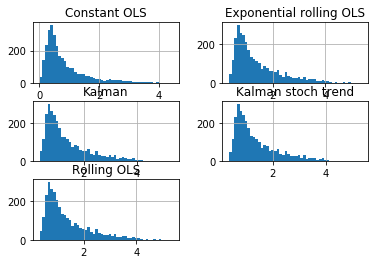

In [249]:
performance_record_wacc.hist(bins=50)

In [236]:
fk.compute_t_stat(performance_record_wacc, reference='Rolling OLS')

Constant OLS              -66.671928
Exponential rolling OLS     6.419087
Kalman                      9.708781
Kalman stoch trend         27.835801
Rolling OLS                 0.000000
dtype: float64

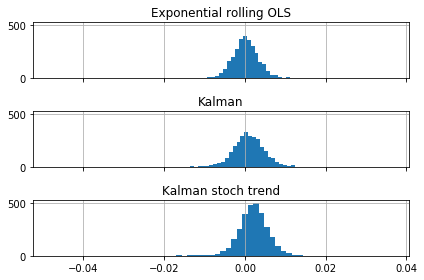

In [237]:
fk.plot_t_stat_differences(performance_record_wacc.iloc[:,1:], reference='Rolling OLS')

In [238]:
fk.compute_wilcoxon_pvalue(performance_record_wacc, reference='Rolling OLS')

C:\Users\Sam\Anaconda2\envs\python3\lib\site-packages\scipy\stats\morestats.py:2397: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
C:\Users\Sam\Anaconda2\envs\python3\lib\site-packages\scipy\stats\morestats.py:2422: RuntimeWarning: invalid value encountered in double_scalars
  z = (T - mn - correction) / se
C:\Users\Sam\Anaconda2\envs\python3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Sam\Anaconda2\envs\python3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Sam\Anaconda2\envs\python3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Constant OLS                0.000000e+00
Exponential rolling OLS     5.632707e-06
Kalman                      4.559441e-33
Kalman stoch trend         1.978979e-184
Rolling OLS                          NaN
dtype: float64

In [243]:
fk.compute_wilcoxon_pvalue(performance_record_wacc, reference='Kalman')

C:\Users\Sam\Anaconda2\envs\python3\lib\site-packages\scipy\stats\morestats.py:2397: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
C:\Users\Sam\Anaconda2\envs\python3\lib\site-packages\scipy\stats\morestats.py:2422: RuntimeWarning: invalid value encountered in double_scalars
  z = (T - mn - correction) / se
C:\Users\Sam\Anaconda2\envs\python3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Sam\Anaconda2\envs\python3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Sam\Anaconda2\envs\python3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Constant OLS               0.000000e+00
Exponential rolling OLS    1.114495e-29
Kalman                              NaN
Kalman stoch trend         1.966967e-48
Rolling OLS                4.559441e-33
dtype: float64

In [239]:
performance_record_mse.describe()

,Constant OLS,Exponential rolling OLS,Kalman,Kalman stoch trend,Rolling OLS
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,4.463013,1.055783,1.064584,1.059445,1.059884
std,4.098330,0.068101,0.104052,0.121149,0.085148
min,1.051090,0.981531,0.973180,0.977039,0.982650
25%,1.763706,1.028898,1.023990,1.022657,1.029808
50%,2.774343,1.042641,1.039004,1.035312,1.043383
75%,5.964346,1.060506,1.068223,1.053175,1.062311
max,39.093232,2.201237,2.735111,2.925101,2.493643


In [240]:
fk.compute_t_stat(performance_record_mse, reference='Rolling OLS')

Constant OLS               45.961094
Exponential rolling OLS   -12.137524
Kalman                     10.211950
Kalman stoch trend         -0.600995
Rolling OLS                 0.000000
dtype: float64

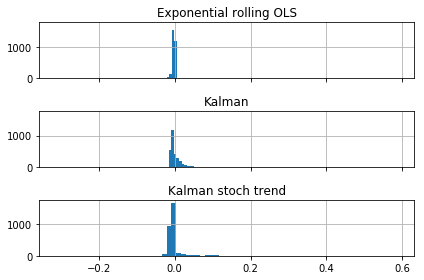

In [241]:
fk.plot_t_stat_differences(performance_record_mse.iloc[:,1:], reference='Rolling OLS')

In [242]:
fk.compute_wilcoxon_pvalue(performance_record_mse, reference='Rolling OLS')

C:\Users\Sam\Anaconda2\envs\python3\lib\site-packages\scipy\stats\morestats.py:2397: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
C:\Users\Sam\Anaconda2\envs\python3\lib\site-packages\scipy\stats\morestats.py:2422: RuntimeWarning: invalid value encountered in double_scalars
  z = (T - mn - correction) / se
C:\Users\Sam\Anaconda2\envs\python3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Sam\Anaconda2\envs\python3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Sam\Anaconda2\envs\python3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Constant OLS                0.000000e+00
Exponential rolling OLS    6.774260e-179
Kalman                      5.818670e-03
Kalman stoch trend         3.935845e-214
Rolling OLS                          NaN
dtype: float64

## Save data

In [244]:
import pickle
with open('20190314-performance_record.pickle', 'wb') as f:
    pickle.dump({"Weighted accuracy": performance_record_wacc, "MSE": performance_record_mse}, f)

In [253]:
with open('20190314-performance_record.pickle', 'rb') as f:
    ls = pickle.load(f)
ls['Weighted accuracy'] = performance_record_wacc
ls['MSE'] = performance_record_mse

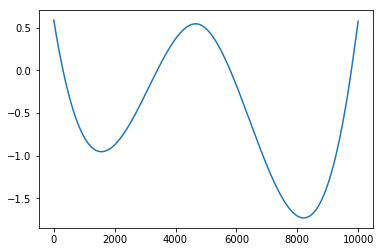

In [747]:
random_sensitivity = create_random_sensitivity(timespan)
#values = splev(factors.index, random_sensitivity)

plt.figure()
random_sensitivity.plot()
#plt.plot(factors.index, values)
plt.show()